In [1]:

import os, sys
#parentdir = os.path.dirname(os.path.dirname(__file__))
sys.path.append('/home/dtyagi/FenicsConcrete')
#print(parentdir)
import numpy as np
#import matplotlib.pyplot as plt
from probeye.definition.inverse_problem import InverseProblem
from probeye.definition.forward_model import ForwardModelBase
from probeye.definition.distribution import Normal, Uniform, LogNormal
from probeye.definition.sensor import Sensor
from probeye.definition.likelihood_model import GaussianLikelihoodModel

# local imports (problem solving)
from probeye.inference.scipy.solver import MaxLikelihoodSolver
from probeye.inference.emcee.solver import EmceeSolver
from probeye.inference.dynesty.solver import DynestySolver

# local imports (inference data post-processing)
from probeye.postprocessing.sampling_plots import create_pair_plot
from probeye.postprocessing.sampling_plots import create_posterior_plot
from probeye.postprocessing.sampling_plots import create_trace_plot
import fenicsX_concrete
from scipy import optimize

def collect_sensor_solutions(model_solution, total_sensors):
    counter=0
    disp_model = np.zeros((total_sensors,2))
    for i in model_solution:
        disp_model[counter] = model_solution[i].data[-1]
        counter += 1
    return disp_model

# Synthetic data generation
para = fenicsX_concrete.Parameters()  # using the current default values
para['problem'] = 'cantilever_beam' #'tensile_test' #

# N/m², m, kg, sec, N
para['rho'] = 7750
para['g'] = 9.81
para['E'] = 210e9
para['length'] = 1
para['breadth'] = 0.2
para['load'] = 100

# MPa, mm, kg, sec, N
#para['rho'] = 7750e-9 #kg/mm³
#para['g'] = 9.81#e3 #mm/s² for units to be consistent g must be given in m/s².
#para['E'] = 210e3 #N/mm² or MPa
#para['length'] = 1000
#para['breadth'] = 200
#para['load'] = 100e-6 #N/mm²

para['nu'] = 0.28
para['num_elements_length'] = 30
para['num_elements_breadth'] = 20
para['dim'] = 2

experiment = fenicsX_concrete.concreteSlabExperiment(para)         # Specifies the domain, discretises it and apply Dirichlet BCs
problem = fenicsX_concrete.LinearElasticity(experiment, para)      # Specifies the material law and weak forms.

sensor = []
for i in range(10): #20
    sensor.append(fenicsX_concrete.sensors.DisplacementSensor(np.array([[para['length']/10*(i+1), 0.2, 0]]))) #1/20
    sensor.append(fenicsX_concrete.sensors.DisplacementSensor(np.array([[para['length']/10*(i+1), 0, 0]])))

number_of_sensors = len(sensor)

for i in range(len(sensor)):
    problem.add_sensor(sensor[i])

#mt=MemoryTracker()
problem.solve()
displacement_data = collect_sensor_solutions(problem.sensors, number_of_sensors)

#Clean the sensor data for the next simulation run
problem.clean_sensor_data()

max_disp_value_ver = np.amax(np.absolute(displacement_data[:,1]))
max_disp_value_hor = np.amax(np.absolute(displacement_data[:,0]))

min_disp_value_ver = np.amin(np.absolute(displacement_data[:,1]))
min_disp_value_hor = np.amin(np.absolute(displacement_data[:,0]))

sigma_error_hor = 0.1*max_disp_value_hor
sigma_error_ver = 0.1*max_disp_value_ver

np.random.seed(42) 
distortion_hor = np.random.normal(0, 1e-9, (number_of_sensors)) #0.005
distortion_ver = np.random.normal(0, 1e-9, (number_of_sensors)) 

displacement_measured_hor = displacement_data[:,0] + distortion_hor
displacement_measured_ver = displacement_data[:,1] + distortion_ver

displacement_measured = np.stack((displacement_measured_hor, displacement_measured_ver), axis = -1)#.flatten()

#max_disp_value = np.amax(np.absolute(displacement_data[:,1]))
#sigma_error = 0.1*max_disp_value

#np.random.seed(42) 
#distortion = np.random.normal(0, sigma_error, (number_of_sensors,2))

#observed_data = displacement_data + distortion

def forward_model_run(param1, param2, ndim=2):
    problem.lambda_.value = param1 * param2 / ((1.0 + param2) * (1.0 - 2.0 * param2))
    problem.mu.value = param1 / (2.0 * (1.0 + param2))
    problem.solve() 
    #mt("MCMC run")
    model_data = collect_sensor_solutions(problem.sensors, number_of_sensors)
    problem.clean_sensor_data()
    if ndim == 1:
        return model_data[:,1]
    if ndim == 2:
        return model_data


#ForwardModelBase, Sensor objects, interface and response are mandatory.
import math
ProbeyeProblem = InverseProblem("My Problem")

ProbeyeProblem.add_parameter(name = "E", 
                            tex=r"$YoungsModulus$", 
                            info="Young's Modulus",
                            domain="[0, +oo)",
                            prior = Normal(mean=200e9, std=25e9)) # Uniform(low=50.0, high=150) mean=85.0, std=15

ProbeyeProblem.add_parameter(name = "nu", 
                            tex=r"$PoissonsRatio$", 
                            info="Poisson's Ratio",
                            domain="(0, 0.5)",
                            prior = Uniform(low=0.01, high=0.45)) #Uniform(low=0.01, high=0.45) Normal(mean=0.15, std=0.1)math.log(0.15), std=2.3 Uniform(low=0, high=0.45)(mean=0.15, std=0.1)

#ProbeyeProblem.add_parameter(name = "sigma model",
#                            #domain="(0, +oo)",
#                            tex=r"$\sigma model$",
#                            info="Standard deviation, of zero-mean Gaussian noise model",
#                            prior=Uniform(low=0.0, high=0.8))

ProbeyeProblem.add_parameter(name = "sigma_model",
                            #domain="(0, +oo)",
                            #tex=r"$\sigma model$",
                            info="Standard deviation, of zero-mean Gaussian noise model",
                            value=0.0)

ProbeyeProblem.add_parameter(name = "sigma_meas",
                            #domain="(0, +oo)",
                            tex=r"$\sigma meas$",
                            info="Measurement error",
                            prior= Normal(mean=0, std=1e-8)) #0.004

ProbeyeProblem.add_experiment(name="Test1",
                            sensor_data={
                                "hor_disp": displacement_measured[:,0],
                                "ver_disp": displacement_measured[:,1],
                                "dummy": np.zeros((10,))
                            })

class FwdModel(ForwardModelBase):
    def interface(self):
        self.parameters = ["E", "nu"]   #E and nu must have been already defined beforehand using add_parameter. # three attributes are must here.
        self.input_sensors = Sensor("dummy") #sensor provides a way for forward model to interact with experimental data.
        self.output_sensors = [Sensor("hor_disp", std_model="sigma_model"),
                                Sensor("ver_disp", std_model="sigma_model")]

    def response(self, inp: dict) -> dict:    #forward model evaluation
        #x = inp["x"] Don't need it as weight is already given in equations
        m = inp["E"]
        b = inp["nu"]
        displacement_results = forward_model_run(m, b)
        return {"hor_disp" : displacement_results[:,0],
                "ver_disp": displacement_results[:,1]}

ProbeyeProblem.add_forward_model(FwdModel("CantileverModel"), experiments=["Test1"])

ProbeyeProblem.add_likelihood_model(
    GaussianLikelihoodModel(experiment_name="Test1",
    model_error="additive",
    measurement_error="sigma_meas")
)

emcee_solver = EmceeSolver(ProbeyeProblem)
inference_data = emcee_solver.run(n_steps=175, n_initial_steps=75,n_walkers=20)

true_values = {"E": para['E'], "nu": para['nu']} 




2023-01-06 16:30:26.267 | INFO     | # ================================================================================================ # | probeye.subroutines:print_probeye_header:620
2023-01-06 16:30:26.267 | INFO     | #                                                                                                  # | probeye.subroutines:print_probeye_header:620
2023-01-06 16:30:26.269 | INFO     | #                                            dP                                                    # | probeye.subroutines:print_probeye_header:620
2023-01-06 16:30:26.270 | INFO     | #                                            88                                                    # | probeye.subroutines:print_probeye_header:620
2023-01-06 16:30:26.271 | INFO     | #                  88d888b. 88d888b..d8888b. 88d888b. .d8888b. dP    dP .d8888b.                   # | probeye.subroutines:print_probeye_header:620
2023-01-06 16:30:26.272 | INFO     | #                  88'  `88 88'     8

100%|██████████| 175/175 [00:21<00:00,  8.09it/s]

2023-01-06 16:30:56.271 | INFO     | Sampling of the posterior distribution completed: 175 steps and 20 walkers.                          | probeye.inference.emcee.solver:run:255
2023-01-06 16:30:56.271 | INFO     | Total run-time (including initial sampling): 29s.                                                    | probeye.inference.emcee.solver:run:259
2023-01-06 16:30:56.272 | INFO     |                                                                                                      | probeye.inference.emcee.solver:run:260
2023-01-06 16:30:56.273 | INFO     | Summary of sampling results (emcee)                                                                  | probeye.inference.emcee.solver:run:261
2023-01-06 16:30:56.276 | INFO     |                        mean           median             sd               5%              95%        | probeye.inference.emcee.solver:emcee_summary:137
2023-01-06 16:30:56.277 | INFO     | ----------  ---------------  ---------------  ------------

  warnings.warn(



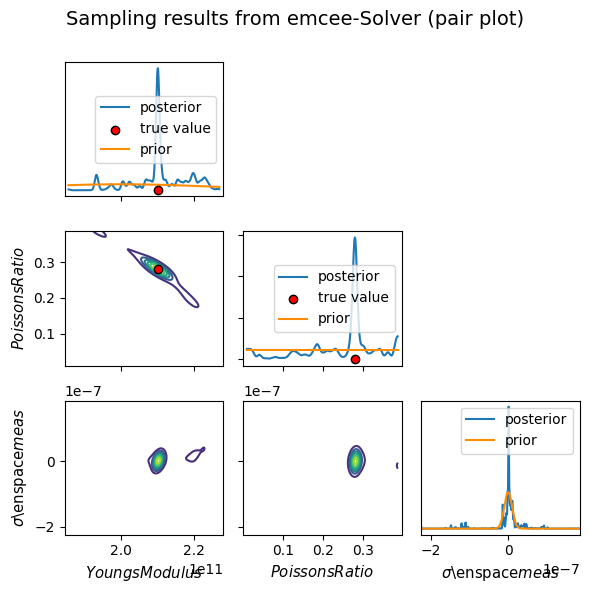

In [2]:
# this is an overview plot that allows to visualize correlations
pair_plot_array = create_pair_plot(
    inference_data,
    emcee_solver.problem,
    true_values=true_values,
    focus_on_posterior=True,
    show_legends=True,
    title="Sampling results from emcee-Solver (pair plot)",
)

In [ ]:
trace_plot_array = create_trace_plot(
    inference_data,
    emcee_solver.problem,
    title="Sampling results from emcee-Solver (trace plot)",
)